#### Biases as Diagonals

We now consider $W$ to be symmetric with the biases filled in the entries of the previously zero diagonals. Considering $x$ and $\tilde{x}$ be two states that are just one hop away,

$$E_{x}(\theta)-E_{\tilde{x}}(\theta) =-\frac{1}{2}x^TWx + \frac{1}{2}\tilde{x}^TW\tilde{x}$$

we can do a simple expansion which gives 

$$ \frac{1}{2}(\tilde{x}^TW\tilde{x} -\tilde{x}^TWx + \tilde{x}^TWx - x^TWx )$$

after some simplification we get

$$\frac{1}{2}z^TWy$$

where $z = \tilde{x} + x$ and $y = \tilde{x} -x$. Without loss of generality, let the following be given which $h$ being the index where the one hop occur,

$$\tilde{x}=\begin{pmatrix}x_1\\ \vdots\\ x_h\\ \vdots\\ x_n\end{pmatrix} \quad x = \begin{pmatrix}x_1\\ \vdots\\1-x_h\\ \vdots\\ x_n\end{pmatrix}$$

Expressing $z$ and $y$ explicitly, we have

$$z=\begin{pmatrix}2x_1\\ \vdots\\ 1\\ \vdots\\ 2x_n\end{pmatrix} \quad y = \begin{pmatrix}0\\ \vdots\\2x_h-1\\ \vdots\\ 0\end{pmatrix}$$


thus

$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta)) = \frac{1}{4}z^TWy = \begin{pmatrix}x_1(x_h-1/2)W_{1h}, \ldots,1/2(x_h-1/2)W_{hh}\ldots,x_n(x_h-1/2)W_{nh} \end{pmatrix} $$

We can then factorize the common $x_h - 1/2$ term out and further simply the expression

$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta))=\frac{1}{4}z^TWy = (x_h-1/2)\ast(W_{h1}x_1+...+W_{hn}x_n - W_{hh}x_h+ 1/2 W_{hh})$$

Let $Z = Wx$ and $\delta = x_h - 1/2$,

$$(x_h-1/2)*(Z_h - W_{hh}(x_h-1/2))\quad\text{where subscript $h$ means for row $h$}$$

$$\delta * Z - 1/4 * diag(W)\quad\text{ since } \delta^2 = 1/4$$


Do a more complete writeup of MPF

In [8]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit
from datetime import datetime
from mpfutils import load_data


%matplotlib inline

In [9]:
class mpf(object):
    """
    Minimum probability flow with bias in the diagonals
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)


        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        self.W = W
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W]
    
    
    def cost(self, lr = 1e-2):
        """
        Returns the cost. 
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print (str(datetime.now()))
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
#         cost = T.mean(T.exp(1/self.temperature * (-(self.x - 0.5) * T.dot(self.x, self.W)) \
#                               - 0.25 * T.diag(self.W)))
        cost = T.mean(T.exp(1/self.temperature * (-(self.x - 0.5) * T.dot(self.x, self.W)) \
                              - 0.25 * T.diag(self.W)))

        Wgrad = T.grad(cost, self.W) 
        Wupdate = 0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T) # transpose in Theano is same as Numpy
#         Wupdate = self.W - lr * Wgrad
        updates = [(self.W, Wupdate)]

        return cost, updates

SyntaxError: invalid syntax (<ipython-input-9-29f69c80c620>, line 45)

In [10]:
def trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    best_epoch = np.inf
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = np.zeros((units,))
        np.copyto(b_learnt, np.diag(W_learnt))                        
        np.fill_diagonal(W_learnt, 0)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
                            
        mseW = np.linalg.norm(W - (W_learnt))/ (units**2)
        mseb = np.linalg.norm(b - b_learnt)/ units
        mse = mseW + mseb

        if mse < best_mse:
            best_mse = mse
            best_W[0] = W_learnt  
            best_W[1] = mseW
            best_b[0] = b_learnt  
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f, Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse,  (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10))
#     fig, ax = plt.subplots(figsize=(20,10))
    fig.tight_layout()
    plt.setp(ax, xticks=np.arange(0,100,16))

#     plt.xticks(np.arange(0,100,16))
    
#     ax.plot(W.reshape(-1,1)[0:100], 'r')
#     ax.plot((-W_learnt).reshape(-1,1)[0:100], 'b')
#     ax.plot(-best_W[0].reshape(-1,1)[0:100], 'g')
#     ax.set_title('W')
#     ax.legend(['W', 'Learnt W','Best W'])
    ax[0,0].plot(W.reshape(-1,1)[0:100], 'r')
    ax[0,0].plot(W_learnt.reshape(-1,1)[0:100], 'b')
    ax[0,0].plot(best_W[0].reshape(-1,1)[0:100], 'g')
    ax[0,0].set_title('W')
    ax[0,0].legend(['W', 'Learnt W','Best W'])
    ax[0,1].plot(W.reshape(-1,1)[101:200], 'r')
    ax[0,1].plot(W_learnt.reshape(-1,1)[101:200], 'b')
    ax[0,1].plot(best_W[0].reshape(-1,1)[101:200], 'g')
    ax[0,1].set_title('W')
    ax[0,1].legend(['W', 'Learnt W','Best W'])
    ax[1,0].plot(W.reshape(-1,1)[201:256], 'r')
    ax[1,0].plot(W_learnt.reshape(-1,1)[201:256], 'b')
    ax[1,0].plot(best_W[0].reshape(-1,1)[201:256], 'g')
    ax[1,0].set_title('W')
    ax[1,0].legend(['W', 'Learnt W','Best W'])
    ax[1,1].plot(b.reshape(-1,1), 'r')
    ax[1,1].plot(b_learnt.reshape(-1,1),'b')
    ax[1,1].plot(best_b[0].reshape(-1,1),'g')
    ax[1,1].set_title('b')
    ax[1,1].legend(['b', 'Learnt b','Best b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(best_mse))
    print ('Best W mse: {0}'.format(best_W[1]))
    print ('Best b mse: {0}'.format(best_b[1]))
    print ('Best epoch: {0}'.format(best_epoch))
    print ('=' * 51)

########################MPF########################
2017-04-07 17:11:10.626806
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.079663 mseW: 0.04413, mseb: 0.33050, mse: 0.37463, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.637178 mseW: 0.01521, mseb: 0.26997, mse: 0.28518, Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.636348 mseW: 0.01421, mseb: 0.26997, mse: 0.28417, Time Elasped: 0.69 
Training epoch 300/1000, Cost: 0.636237 mseW: 0.01431, mseb: 0.26996, mse: 0.28428, Time Elasped: 1.07 
Training epoch 400/1000, Cost: 0.636215 mseW: 0.01441, mseb: 0.26996, mse: 0.28438, Time Elasped: 1.48 
Training epoch 500/1000, Cost: 0.636209 mseW: 0.01447, mseb: 0.26996, mse: 0.28443, Time Elasped: 1.84 
Training epoch 600/1000, Cost: 0.636208 mseW: 0.01450, mseb: 0.26996, mse: 0.28446, Time Elasped: 2.21 
Training epoch 700/1000, Cost: 0.636207 mseW: 0.01451, mseb: 0.26996, mse: 0.28448, Time Elasped: 2.57 
Training

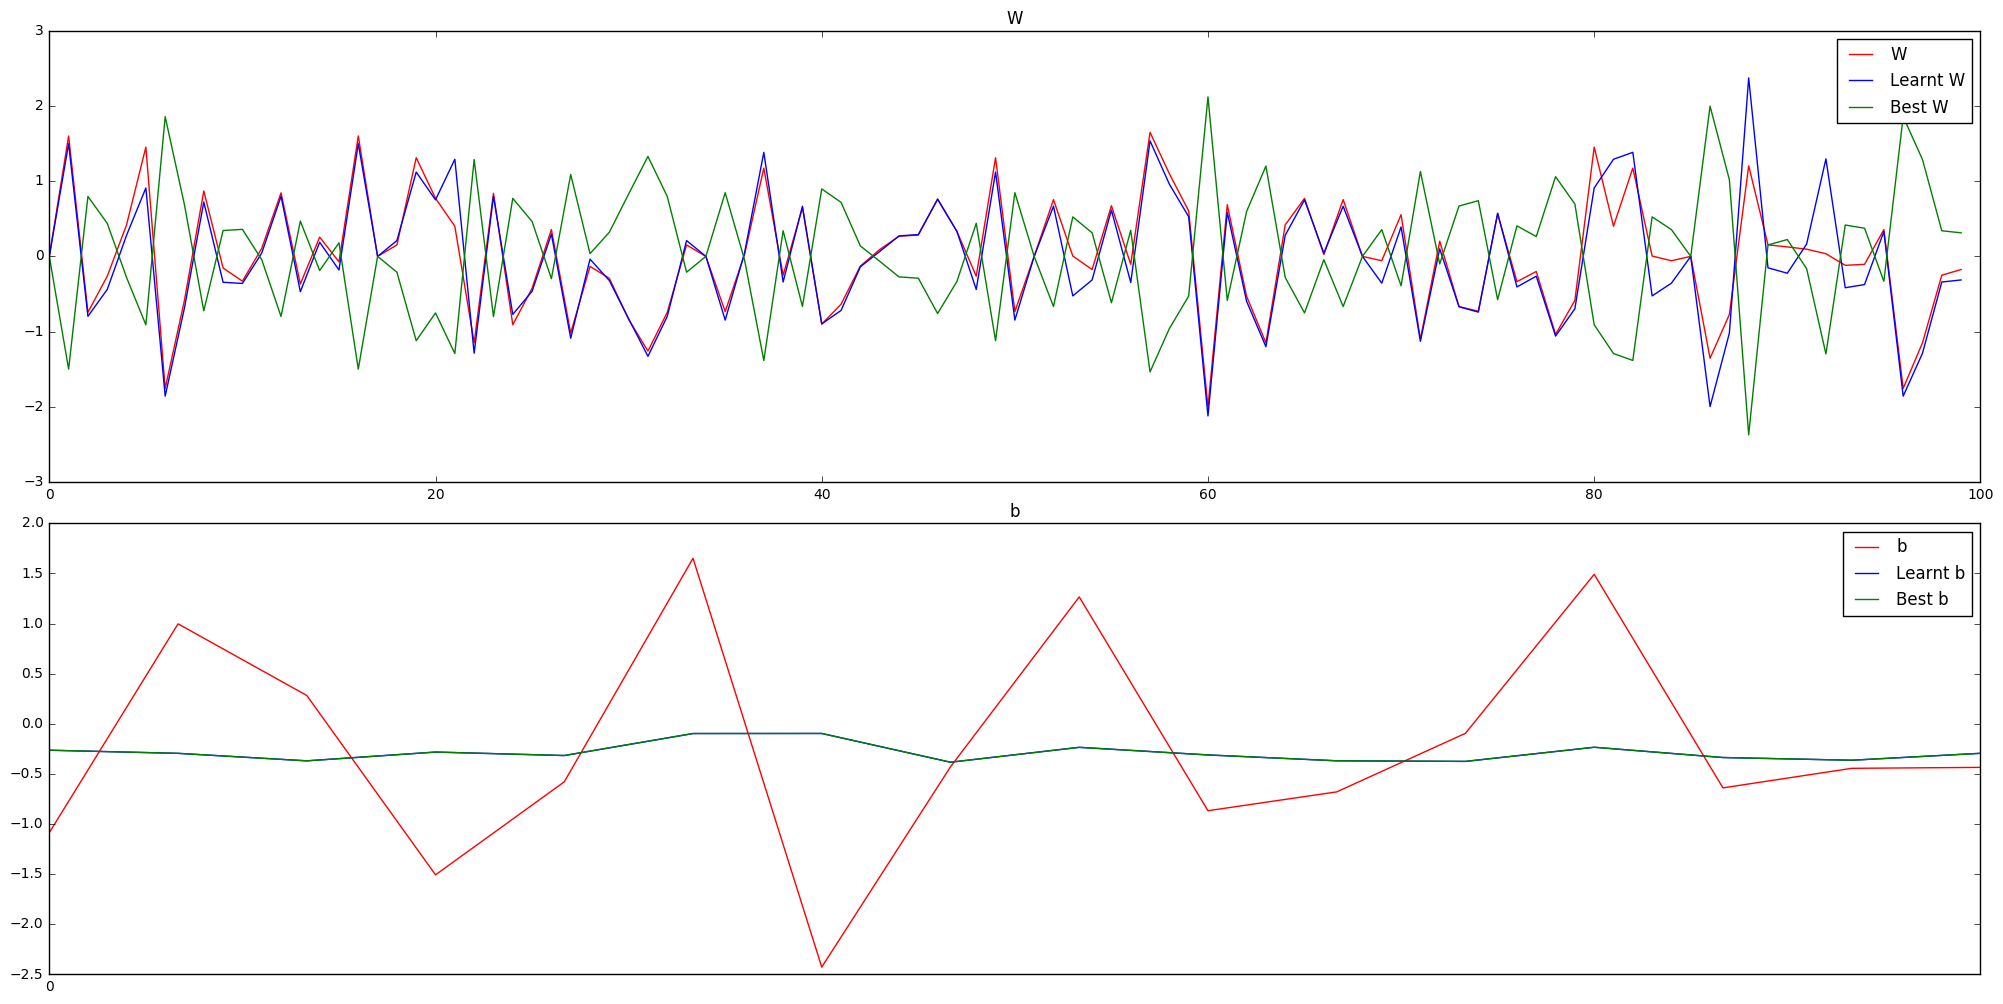

In [32]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-07 17:15:46.774806
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.131378 mseW: 0.04426, mseb: 0.32480, mse: 0.36906, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.637024 mseW: 0.01513, mseb: 0.26997, mse: 0.28510, Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.636335 mseW: 0.01428, mseb: 0.26997, mse: 0.28425, Time Elasped: 0.68 
Training epoch 300/1000, Cost: 0.636237 mseW: 0.01435, mseb: 0.26997, mse: 0.28431, Time Elasped: 1.01 
Training epoch 400/1000, Cost: 0.636216 mseW: 0.01442, mseb: 0.26996, mse: 0.28439, Time Elasped: 1.34 
Training epoch 500/1000, Cost: 0.636210 mseW: 0.01447, mseb: 0.26996, mse: 0.28443, Time Elasped: 1.67 
Training epoch 600/1000, Cost: 0.636208 mseW: 0.01450, mseb: 0.26996, mse: 0.28446, Time Elasped: 1.99 
Training epoch 700/1000, Cost: 0.636207 mseW: 0.01451, mseb: 0.26996, mse: 0.28448, Time Elasped: 2.32 
Training

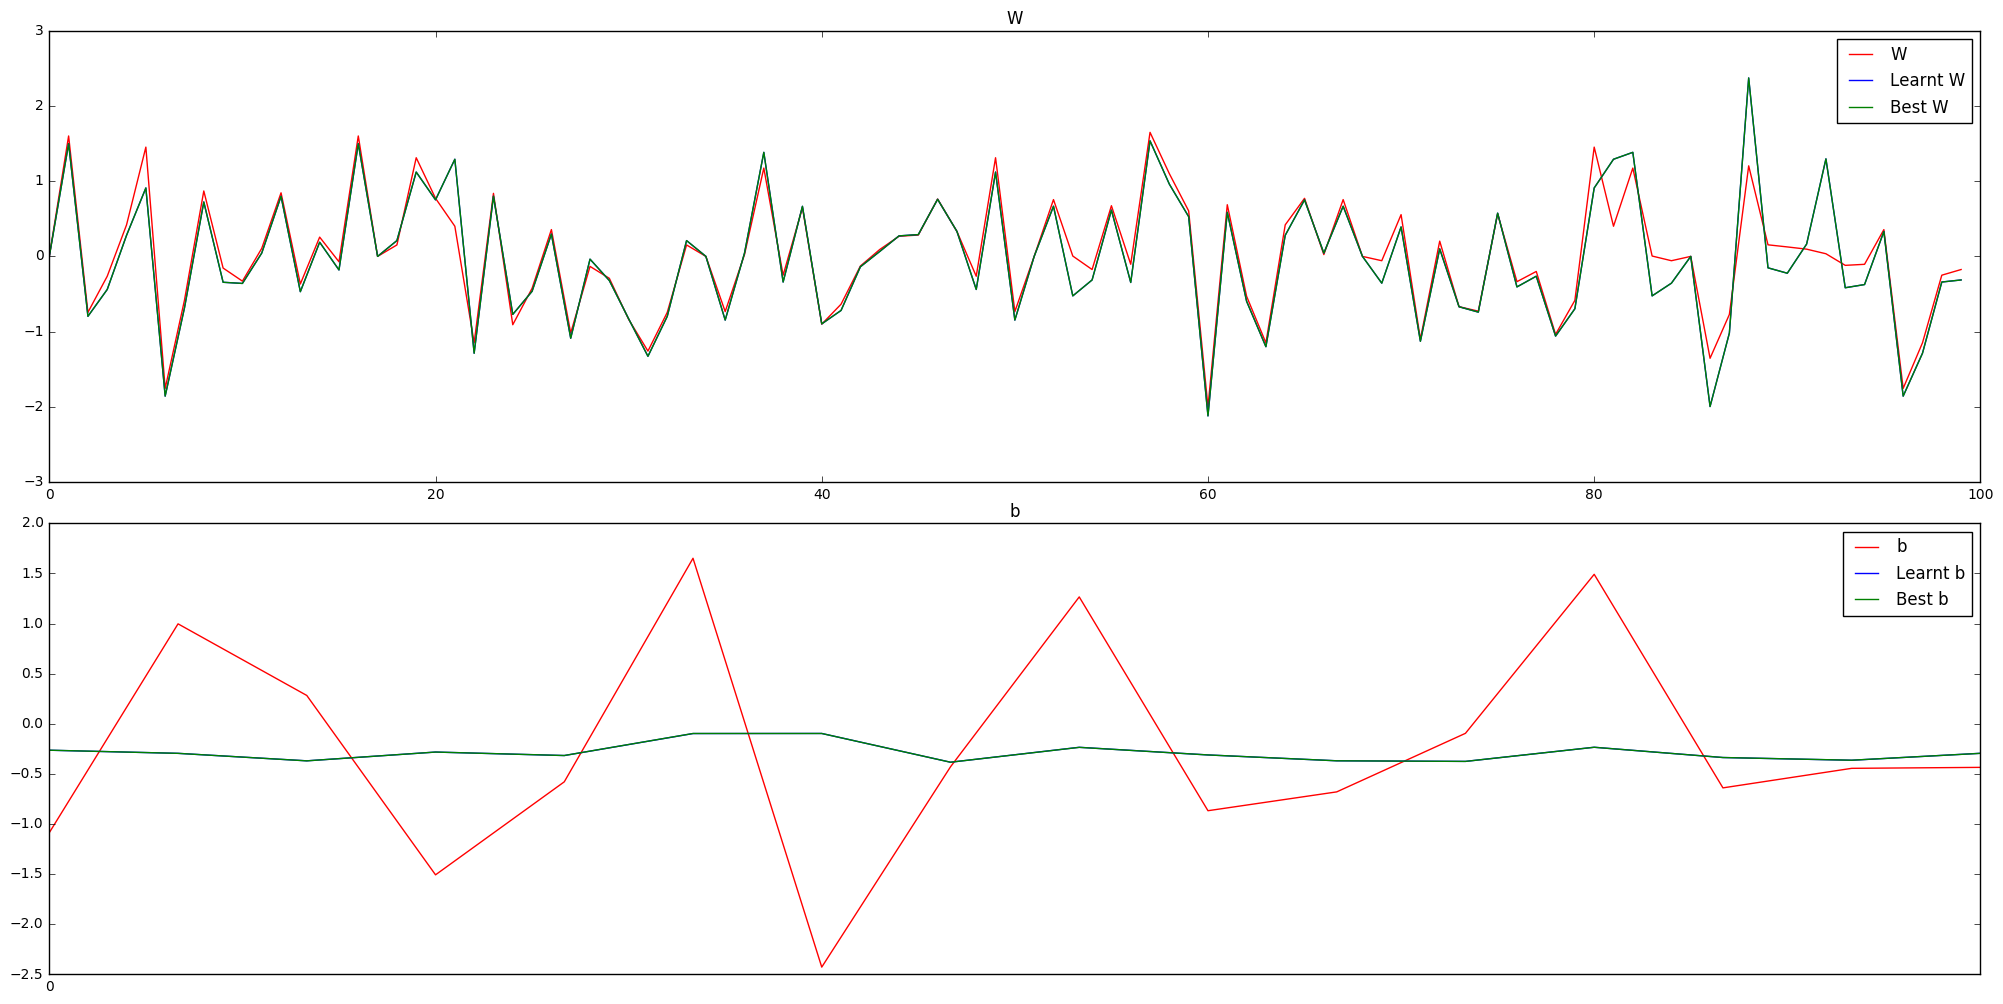

In [34]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-07 17:27:01.108506
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.136317 mseW: 0.04239, mseb: 0.32307, mse: 0.36546, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.636956 mseW: 0.01463, mseb: 0.26998, mse: 0.28461, Time Elasped: 0.43 
Training epoch 200/1000, Cost: 0.636308 mseW: 0.01412, mseb: 0.26997, mse: 0.28409, Time Elasped: 0.82 
Training epoch 300/1000, Cost: 0.636227 mseW: 0.01431, mseb: 0.26997, mse: 0.28427, Time Elasped: 1.20 
Training epoch 400/1000, Cost: 0.636212 mseW: 0.01442, mseb: 0.26996, mse: 0.28439, Time Elasped: 1.53 
Training epoch 500/1000, Cost: 0.636209 mseW: 0.01448, mseb: 0.26996, mse: 0.28444, Time Elasped: 1.86 
Training epoch 600/1000, Cost: 0.636207 mseW: 0.01450, mseb: 0.26996, mse: 0.28447, Time Elasped: 2.19 
Training epoch 700/1000, Cost: 0.636207 mseW: 0.01452, mseb: 0.26996, mse: 0.28448, Time Elasped: 2.52 
Training

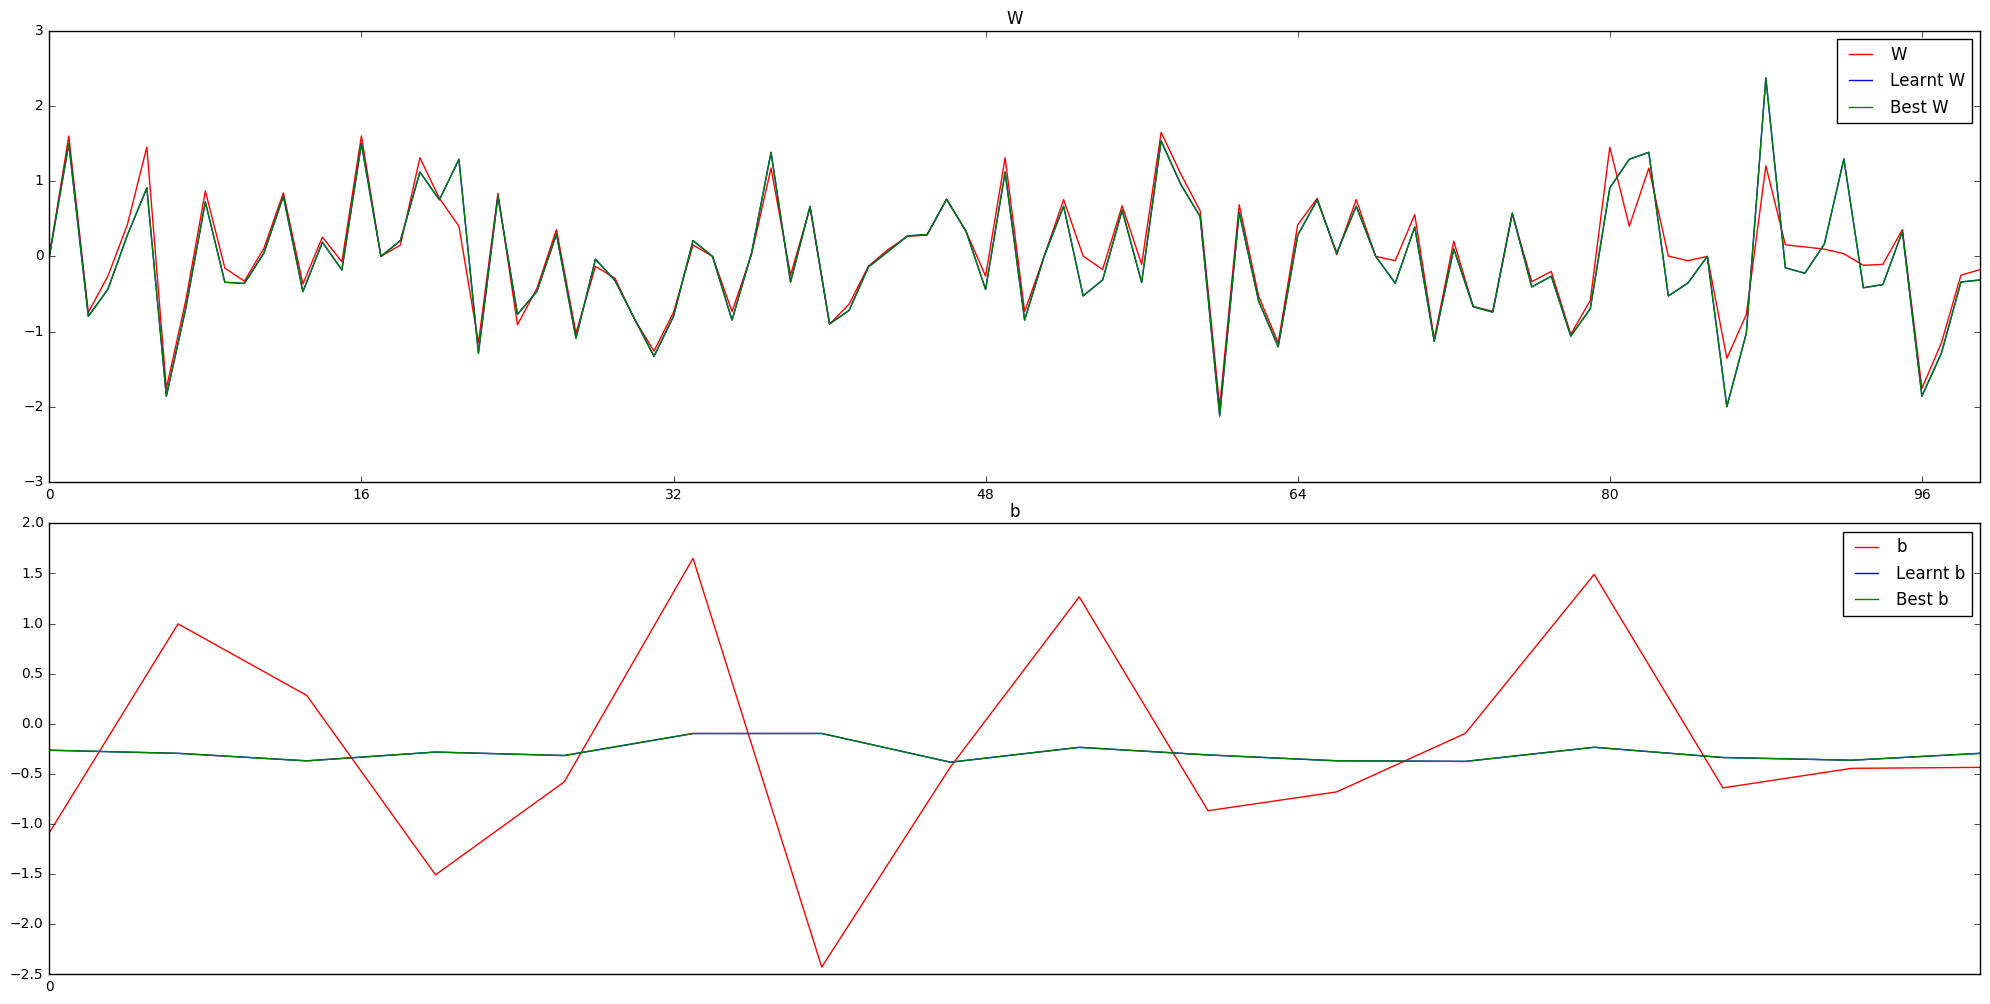

In [41]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-07 20:35:24.463488
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 1.096076 mseW: 0.05386, mseb: 0.31579, mse: 0.36964, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.635663 mseW: 0.08652, mseb: 0.26945, mse: 0.35596, Time Elasped: 0.31 
Training epoch 200/1000, Cost: 0.634862 mseW: 0.08952, mseb: 0.26939, mse: 0.35891, Time Elasped: 0.62 
Training epoch 300/1000, Cost: 0.634714 mseW: 0.09061, mseb: 0.26936, mse: 0.35997, Time Elasped: 0.93 
Training epoch 400/1000, Cost: 0.634676 mseW: 0.09111, mseb: 0.26935, mse: 0.36046, Time Elasped: 1.24 
Training epoch 500/1000, Cost: 0.634665 mseW: 0.09135, mseb: 0.26935, mse: 0.36070, Time Elasped: 1.56 
Training epoch 600/1000, Cost: 0.634661 mseW: 0.09148, mseb: 0.26934, mse: 0.36082, Time Elasped: 1.88 
Training epoch 700/1000, Cost: 0.634660 mseW: 0.09155, mseb: 0.26934, mse: 0.36089, Time Elasped: 2.19 
Training

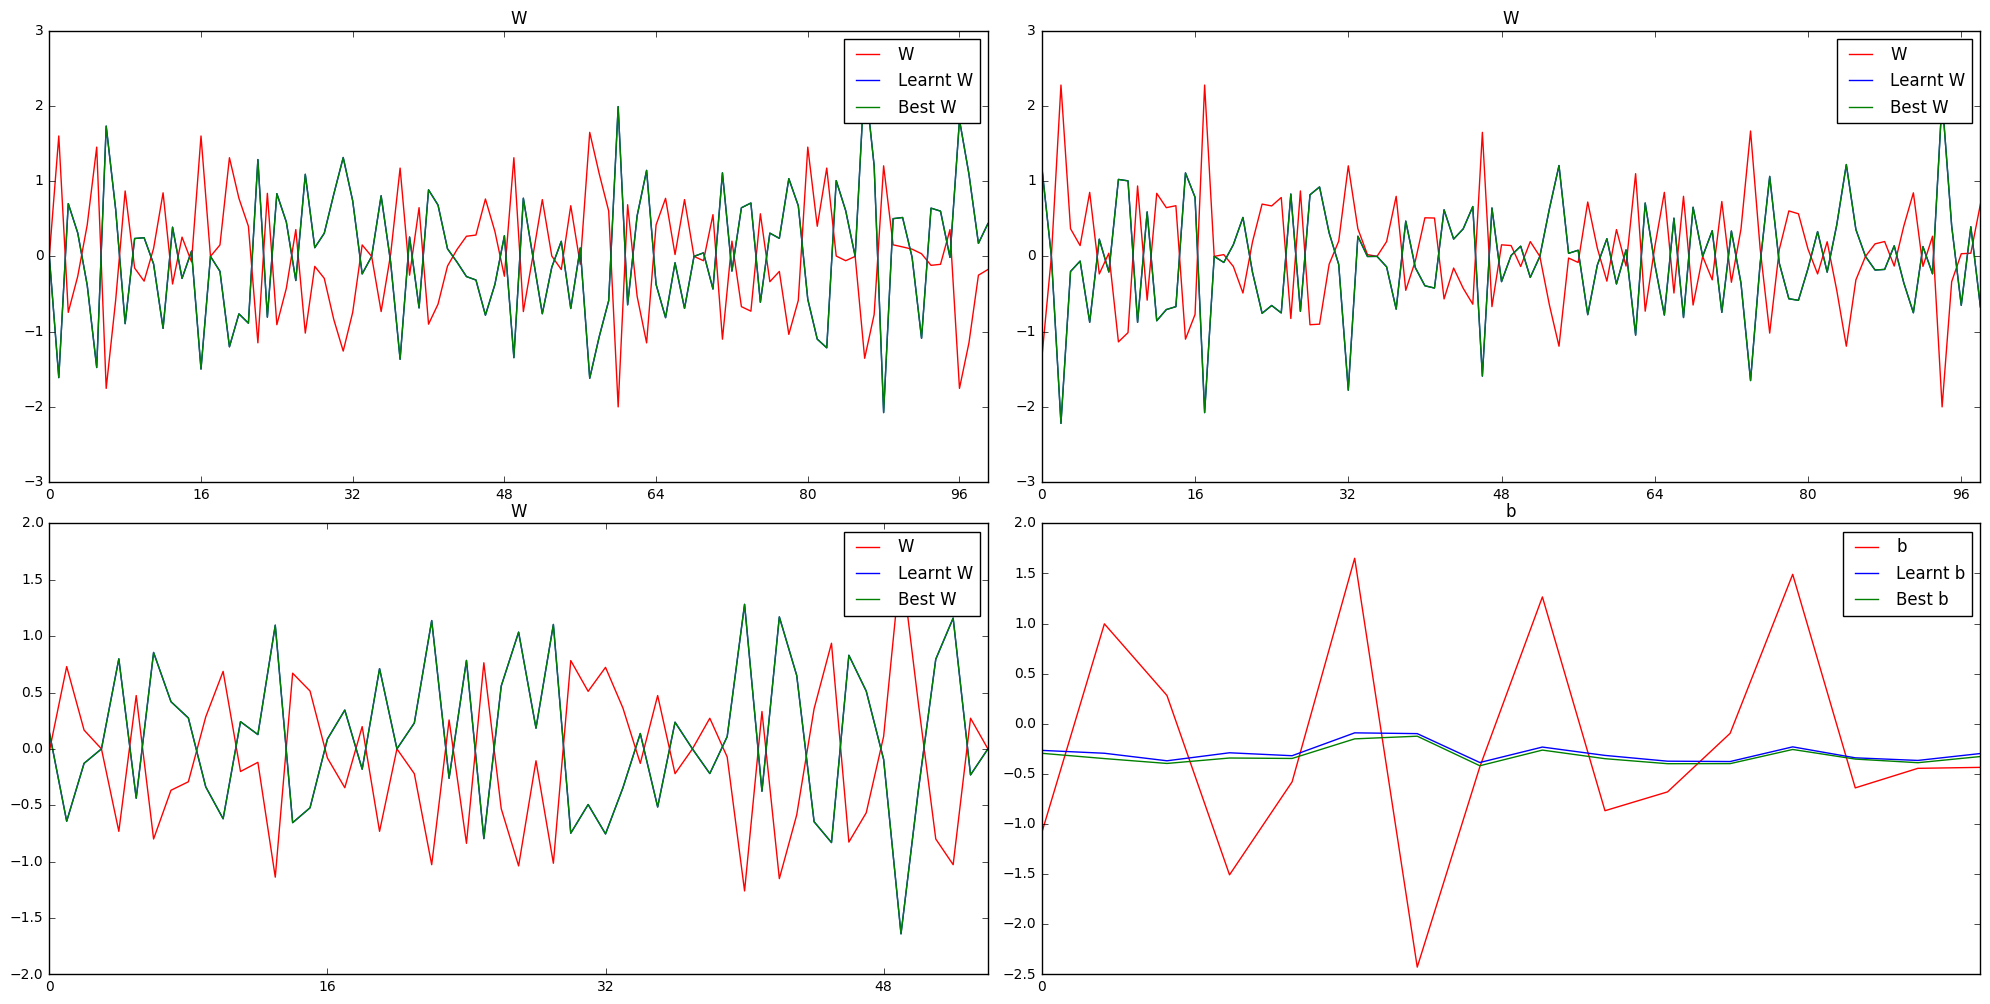

In [61]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-07 20:42:14.252288
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 2.734111 mseW: 0.05109, mseb: 0.30637, mse: 0.35747, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.689665 mseW: 0.06461, mseb: 0.27422, mse: 0.33883, Time Elasped: 0.31 
Training epoch 200/1000, Cost: 0.671050 mseW: 0.07199, mseb: 0.27429, mse: 0.34628, Time Elasped: 0.62 
Training epoch 300/1000, Cost: 0.664434 mseW: 0.07654, mseb: 0.27432, mse: 0.35085, Time Elasped: 0.94 
Training epoch 400/1000, Cost: 0.661446 mseW: 0.07954, mseb: 0.27433, mse: 0.35387, Time Elasped: 1.25 
Training epoch 500/1000, Cost: 0.659869 mseW: 0.08164, mseb: 0.27433, mse: 0.35598, Time Elasped: 1.56 
Training epoch 600/1000, Cost: 0.658938 mseW: 0.08318, mseb: 0.27433, mse: 0.35752, Time Elasped: 1.87 
Training epoch 700/1000, Cost: 0.658338 mseW: 0.08435, mseb: 0.27434, mse: 0.35869, Time Elasped: 2.18 
Trainin

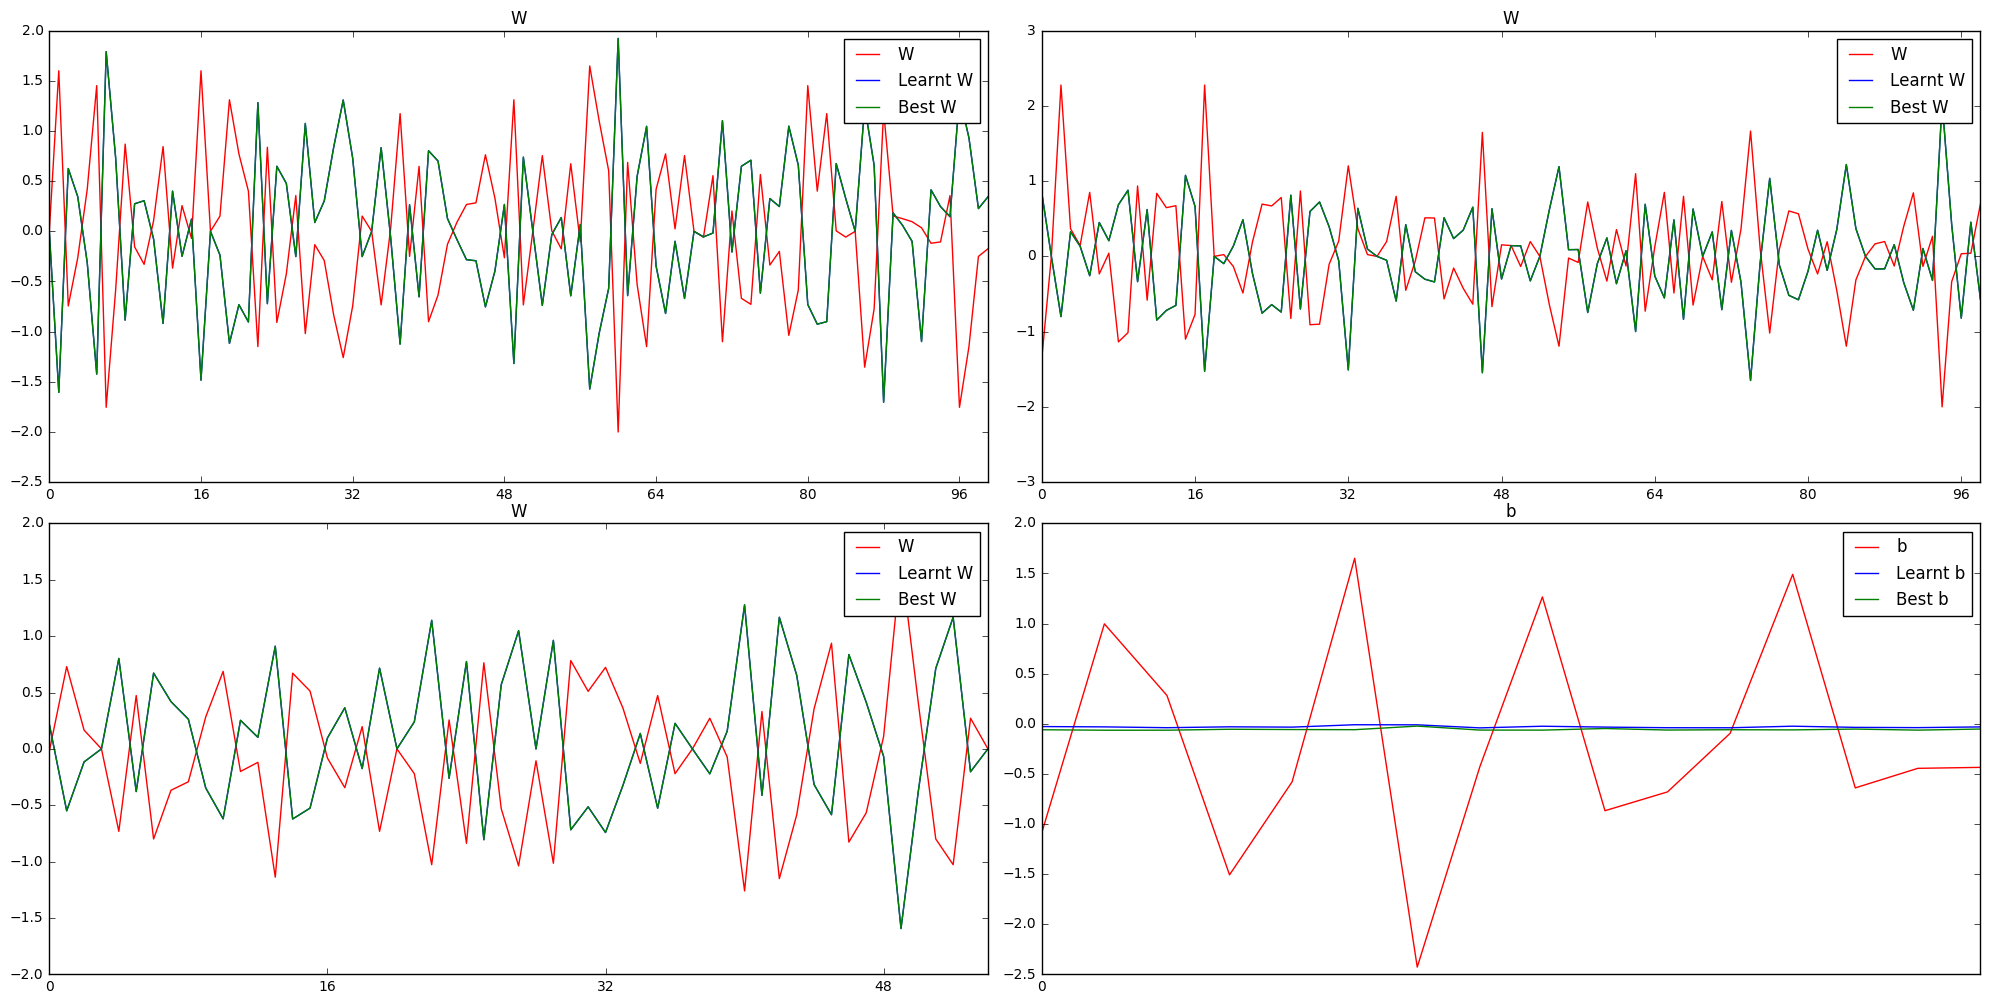

In [62]:
trainmpf(units = 16, lr = 1e-3, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-07 22:58:40.400988
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 2.387556 mseW: 0.05135, mseb: 0.32434, mse: 0.37569, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.688655 mseW: 0.03365, mseb: 0.27820, mse: 0.31185, Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.670212 mseW: 0.02683, mseb: 0.27814, mse: 0.30497, Time Elasped: 0.66 
Training epoch 300/1000, Cost: 0.663701 mseW: 0.02290, mseb: 0.27812, mse: 0.30102, Time Elasped: 0.98 
Training epoch 400/1000, Cost: 0.660757 mseW: 0.02032, mseb: 0.27811, mse: 0.29843, Time Elasped: 1.30 
Training epoch 500/1000, Cost: 0.659193 mseW: 0.01848, mseb: 0.27811, mse: 0.29659, Time Elasped: 1.62 
Training epoch 600/1000, Cost: 0.658261 mseW: 0.01710, mseb: 0.27811, mse: 0.29521, Time Elasped: 1.93 
Training epoch 700/1000, Cost: 0.657654 mseW: 0.01603, mseb: 0.27811, mse: 0.29413, Time Elasped: 2.25 
Trainin

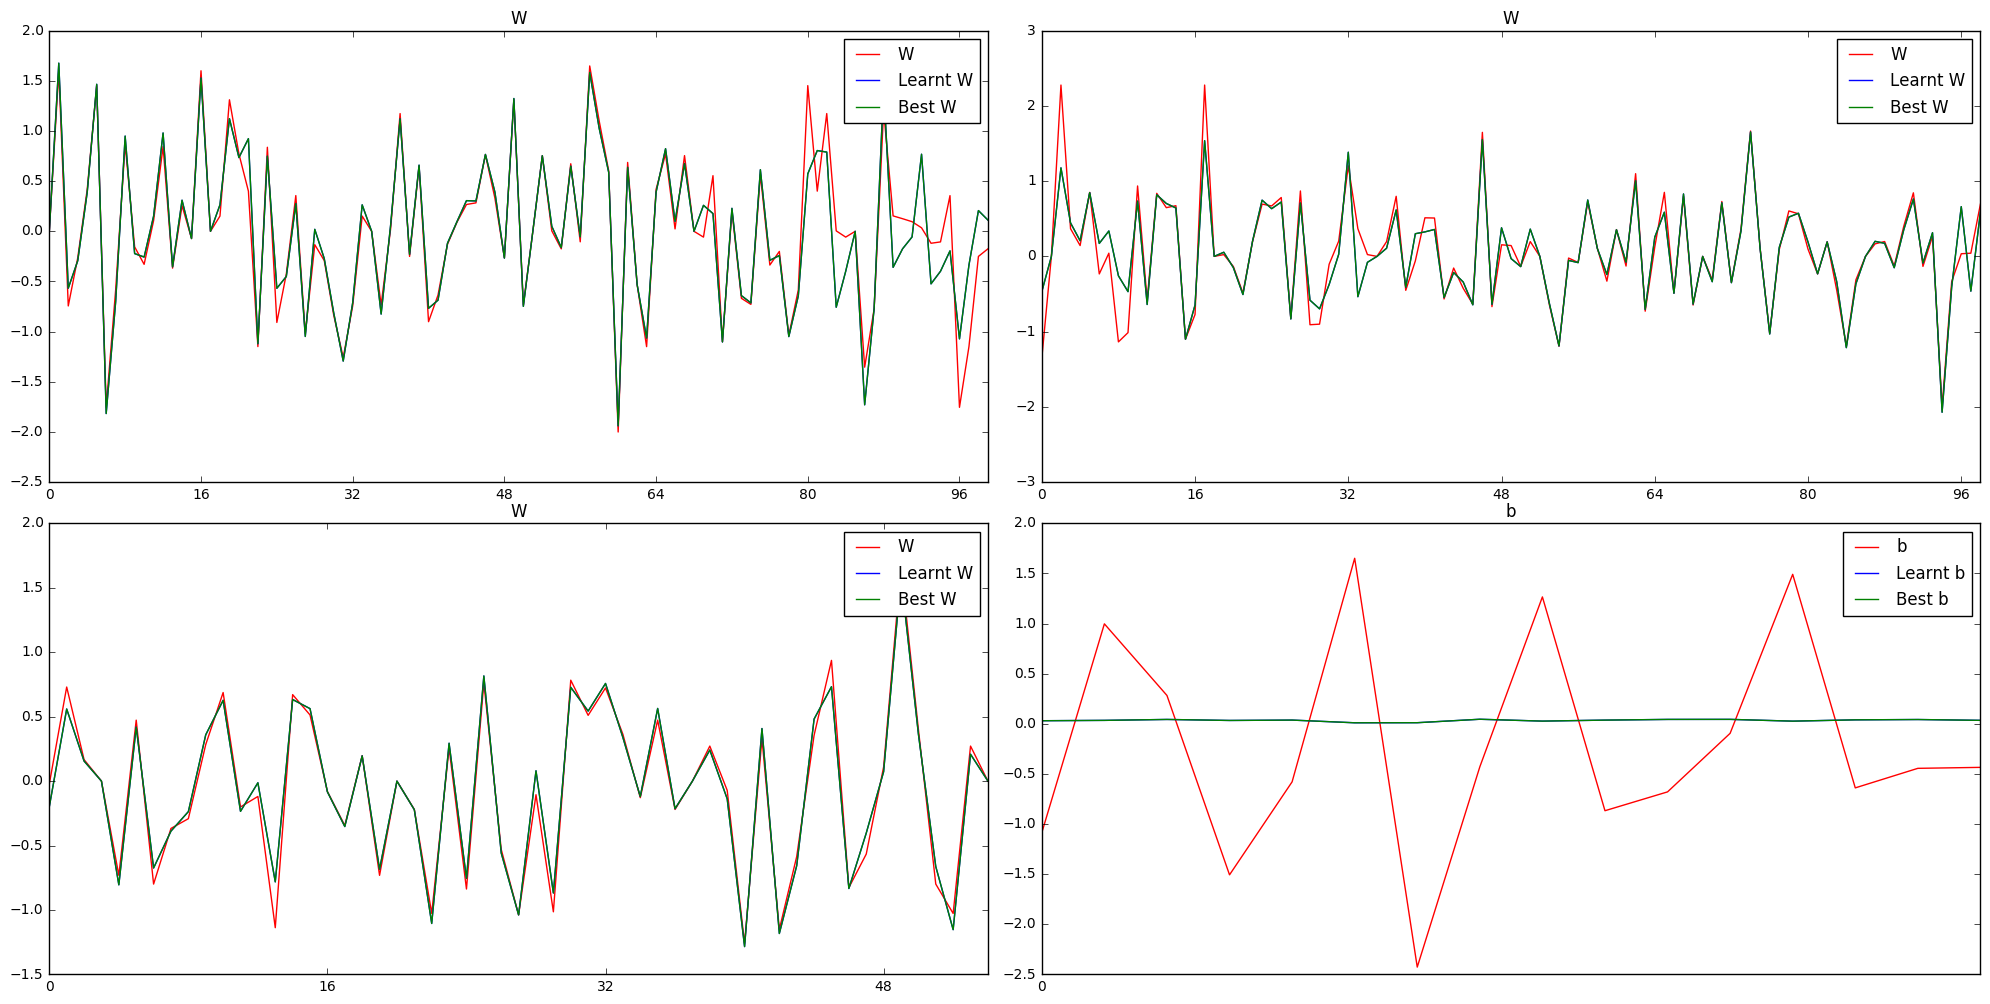

In [68]:
trainmpf(units = 16, lr = 1e-3, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-27 09:49:26.592206
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 2.582970 mseW: 0.05121, mseb: 0.34625, mse: 0.39746, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.677728 mseW: 0.03239, mseb: 0.28037, mse: 0.31276, Time Elasped: 0.43 
Training epoch 200/1000, Cost: 0.662083 mseW: 0.02615, mseb: 0.28025, mse: 0.30640, Time Elasped: 0.84 
Training epoch 300/1000, Cost: 0.656283 mseW: 0.02245, mseb: 0.28019, mse: 0.30264, Time Elasped: 1.27 
Training epoch 400/1000, Cost: 0.653545 mseW: 0.02003, mseb: 0.28016, mse: 0.30019, Time Elasped: 1.81 
Training epoch 500/1000, Cost: 0.652048 mseW: 0.01837, mseb: 0.28014, mse: 0.29851, Time Elasped: 2.21 
Training epoch 600/1000, Cost: 0.651143 mseW: 0.01718, mseb: 0.28013, mse: 0.29732, Time Elasped: 2.65 
Training epoch 700/1000, Cost: 0.650555 mseW: 0.01632, mseb: 0.28013, mse: 0.29645, Time Elasped: 3.07 
Trainin

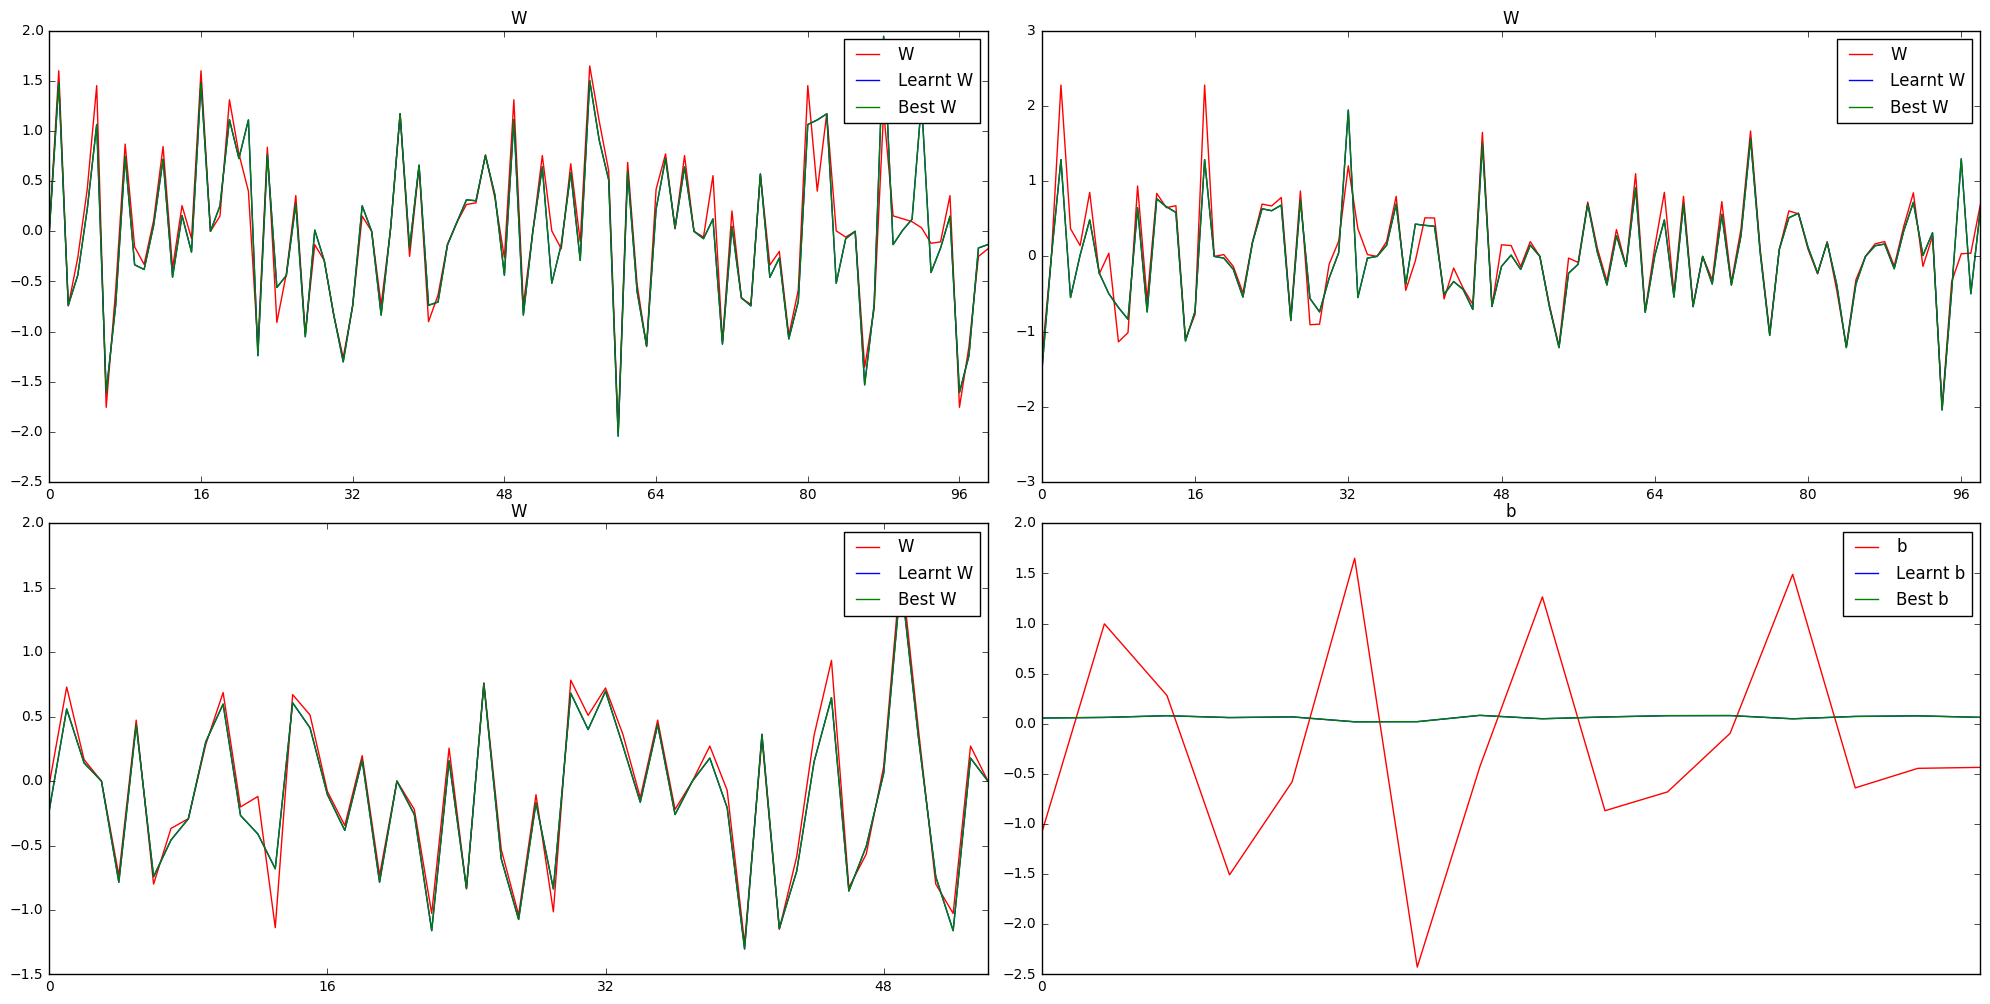

In [4]:
trainmpf(units = 16, lr = 1e-3, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

In [11]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
2017-04-29 23:28:47.529206
Input size: 16
Learning temperature: 1
Learning rate: 0.01


ValueError: Not enough dimensions on Sum{acc_dtype=float64}.0 to reduce on axis 1